# TAX BENEFITS OF OPPORTUNITY ZONES- PREDICTING SALE PRICE IN AMES IOWA

#### By: [Varun Ganti]()

## Table of Contents

- [Problem Statement](#Problem-Statemet)
- [Executive Summary](#Executive-Summary)
- [Data Dictionary](#Data-Dictionary)
- [Loading Data](#Loading-Data)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Conclusion](#Model-Selection)
- [Recommendations](#Reccomendations)
- [Resources](#Resources)




# Problem Statement


The Tax Cuts and Jobs Act created the Opportunity zones program to increase investment in certain specified areas of the country. The city of Ames is an opportunity zone, where real estate developers have been purchasing homes drastically and investing capital gains into houses in this area for specified tax benefits. The AMES economic development commission has provided tax incentives to real estate buyers, in order to increase housing purchases in Ames. My company is an outside consultant that helps predict housing prices for real estate buyers, so they can continue to invest capital gains into other projects in the city of AMES,in order to meet the interests of the commission. This will give buyers a good strategy in investing into houses and will help them forecast capital gains. Our tool will use AMES housing data to identify the best features in order to predict sales price. Our metric to evaluate the model will be R^2. 

# Executive Summary

My approach was to first decide what platforms have this data available. I found that the data is readily avaliable on Kaggle.From initial data review, I hypothesized that the 'Overall Qual', 'TotalSqFt', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual' variables would have the most influence over sales price. The abundance of variables, forced me to dive deeper into the data in order to find the most optimal combinations in order to find the highest scoring model. We want a high majority of the data to be explained by our model. 


EDA helped me not only set up a preprocessing plan for our model, but helped me understand the health of the data One example was that “Total Square feet” showed up high on the correlation heat map, meaning that this variable will be useful in predicting sale price. For preprocessing, I chose to fill all null values wiht na, assuming that those values actually reperesented none of that type. I also created feature engineering for square feet, bathrooms, and porch square feet in order to simplify the model, so I could use those variables in the model.  For modeling, I chose to use linear regression and lasso regression because of the way it focuses on the relationship of features and our predicted variable(sale price). 

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|.84|.84| 
|**Model 2**|*Linear*|.93|.94|
|**Model 3**|*Ridge*|.91|.88|
|**Model 4**|*Lasso*|.91|.88|

My approach to picking the best model, is by assessing the R2 Score. At first, I tried fitting a model with all variables, but decided that is overkill for our clients. I simplified the model by choosing the features with the highest correlations in predicting sale price. I will use Lasso regression to identify correlations close to 0, and remove those from the model. I will asses performance based on R^2 

## Data Dictionary

Refer to Kaggle for Data Description

- [Kaggle Data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

## Loading Data

In [397]:
import warnings
warnings.filterwarnings("ignore") # Shhhh


import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 90210
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [398]:
##Read data. I like to read test and train together because I want to work on both the same
df_train = pd.read_csv('datasets/train.csv')

df_validation = pd.read_csv('datasets/test.csv')

## Data Cleaning

In [399]:
##check first 5 rows. soo many nans!!!!!
df_train.head()


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [400]:
##Check the shape

df_train.shape

(2051, 81)

In [401]:
##Check the shape
df_validation.shape

(878, 80)

One less column, no sales price. Thats What we are Predicting

In [402]:
##Check for Missing Values
all_nan_values = df_train.isnull().sum()[df_train.isnull().sum()  > 0].sort_values(ascending = False)

### Bar Plot for Missing Values

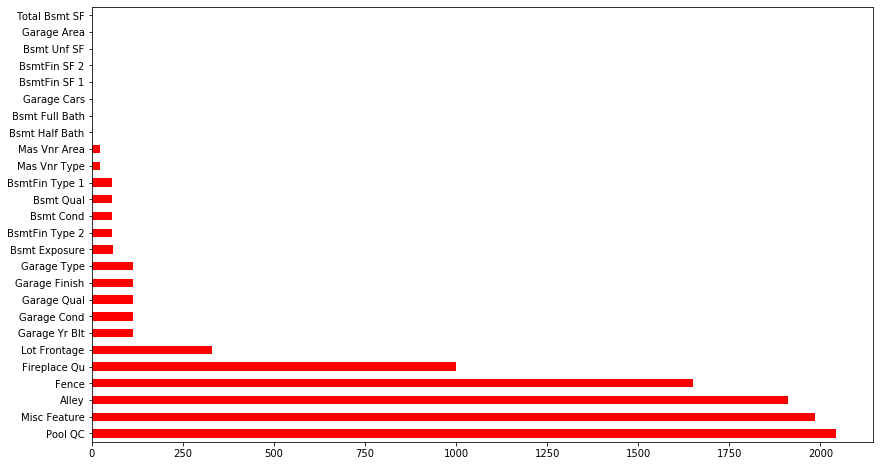

In [403]:
##bar plot of all nan values. easy to see
all_nan_values.plot(kind = 'barh', figsize = (14,8), color = 'red')

Missing Values. Look at data dictionary to see what the Nans should be. Are they just missing values or do they have a value? In fact they do have a value. For example the, Nan's in Pool QC means that the house does not have a pool. This is not misssing data. This will be useful when we fill in those values

In [404]:


df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2.198000e+03,2930.0
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
Lot Frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
Overall Qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
Overall Cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
Year Built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
Year Remod/Add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
Mas Vnr Area,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0


Describe the data. To me, this is the most important step in data cleaning and exploring. Shows me the percentailes of data and average

### Correlation Heat Map based on Sale Price

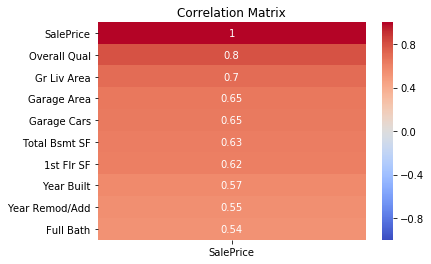

In [405]:
# plt.figure(figsize=(12,12))

plt.title("Correlation Matrix")
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice', ascending = False).head(10), 
            annot = True, cmap = "coolwarm", vmax = 1, vmin = -1)

#### This correlation map shows:

- Overall Quality and Sale Price have a high correlation
- First 10. I did not want to overkill the heat map. Only give me features
- My hypothesis is holding true for now
- This is my preprocessing Correlation heat map. Will use a final one, later for the model


Text(0.5, 0, 'Sale Price($)')

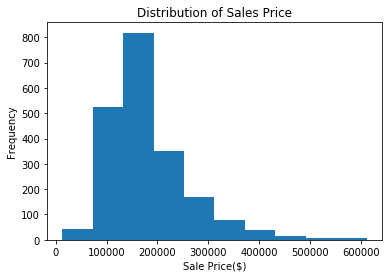

In [406]:
ax = df_train['SalePrice'].plot(kind = 'hist', title = "Distribution of Sales Price"
                           , y = "Frequency(units)")

ax.set_xlabel("Sale Price($)")

Distribution of Sale Price. Bit of a skew in Sale Price. Would like to normalize

#### Distribution Sale Price

### Log transformation of Sales

Text(0.5, 0, 'Log of Sale Price($)')

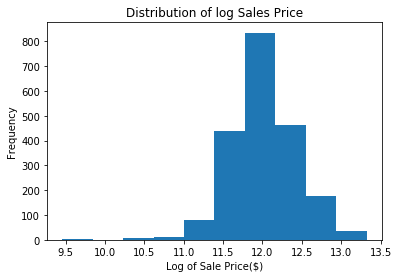

In [407]:
##.apply function with log
df_train['SalePricelog'] = df_train['SalePrice'].apply(np.log)

ax= df_train['SalePricelog'].plot(kind = 'hist', title = "Distribution of log Sales Price")

ax.set_xlabel("Log of Sale Price($)")



Transform SalesPrice to make it more normal distribution

In [408]:
##.drop method
drop_sales_price = ['SalePrice']

df_train =  df_train.drop(drop_sales_price, axis = 1)

Drop sales price. keep the log

In [409]:
##.drop method
id_cols = ['Id', 'PID']

ames_train= df_train.drop(id_cols, axis = 1)

ames_validation = df_validation.drop(id_cols, axis = 1)


Start dropping cols. I want to drop ID and PID. Unique Identifiers. Not merging any df's so why keep those columns

In [410]:
##top 5 of df
ames_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePricelog
0,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,3,2010,WD,11.779129
1,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2009,WD,12.301383
2,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2010,WD,11.599103
3,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,12.066811
4,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,11.838626


### Check Data Types 

In [411]:
ames_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st       

Check data dictionary to see which values make sense. Month sold is 01-12. cant be 13, cant be 0.
I want this to be a string. Same with subclass. It describes something. It is not a numeric column. 

In [412]:
##astype str
ames_train['MS SubClass'] = ames_train['MS SubClass'].astype(str)
ames_validation['MS SubClass'] = ames_validation['MS SubClass'].astype(str)

Find numeric columns and objects. This is the most important step in starting to build the model.Put numeric values into a list. This will help me manipulate this list instead of manipulating dataframe

In [413]:
##get numeric method
features_num = list(ames_train._get_numeric_data())

In [414]:
##Put the strings and objects into a list
features_object = list(ames_train.describe(include = 'object').columns)

In [415]:
##do the same for numbers
test_features_num = list(ames_validation._get_numeric_data())

In [416]:
##do the same for test features

test_features_object = list(ames_validation.describe(include = 'object').columns)

### Fill null values

I filled null values with 0. At first I chose median, but after examining the dictionary
it didnt make sense to fill with the median because a null value for lot frontage, for example, would mean no
lot. The median would skew my data. Choosing 0 for the null values made sense for this because a lot of the
numeric columns features of the house. i assumed null is n="none" or 0.


In [417]:
##fillna method
ames_train[features_num] = ames_train[features_num].fillna(0)
ames_validation[test_features_num] = ames_validation[test_features_num].fillna(0)

Fill null values of objects to NA. According the data dictionary, null values indidicate none. NA is equivalent
to 0. Always refer to the data dictionary. 


In [418]:
##fillna method
ames_train[features_object] = ames_train[features_object].fillna("NA")
ames_validation[test_features_object] = ames_validation[test_features_object].fillna("NA")

Corrupted value. Compared to year built and made it 2007

In [419]:
##.loc method- used to locate row and colummn
ames_train[ames_train['Garage Yr Blt'] == 2207]
ames_train.loc[1699, 'Garage Yr Blt'] = 2007

## EDA

Make a list of nominal cols based on data dictionary. These are no including the ordinal cols. 
deal with ordinal cols 

In [420]:
##list cols in a list object
nominal_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 
                
                'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
                
                'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 
                
                'Sale Type', 'Alley', 'Misc Feature']

Dummy variables for nominal columns. This will help me use them in model

In [421]:
##pd.to get dummies- gets dummy variables
ames_train = pd.get_dummies(ames_train, columns= nominal_cols, drop_first=True)

In [422]:
##pd.to get dummies
ames_validation = pd.get_dummies(ames_validation, columns = nominal_cols , drop_first = True)

### Check for Outlier

Some of the values closer to the right may reperesent outliers

Text(0.5, 0, 'Greater Living Area(Sq FT)')

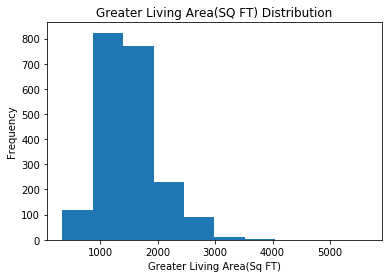

In [423]:
##.plot hist
ax = ames_train['Gr Liv Area'].plot(kind = 'hist',
                               y = 'Frequency',
                               title = 'Greater Living Area(SQ FT) Distribution')


ax.set_xlabel("Greater Living Area(Sq FT)")

#### Looking at the distribution there could be outliers beyond 4,000. Log function to make normal dist

In [424]:
##.log apply. .apply method allows to apply a function to a data frame

ames_train['GRlivingArealog'] = ames_train['Gr Liv Area'].apply(np.log)

ames_train = ames_train.drop('Gr Liv Area', axis = 1)

In [425]:
##do the same for test

ames_validation['GRlivingArealog'] = ames_validation['Gr Liv Area'].apply(np.log)

ames_validation = ames_validation.drop('Gr Liv Area', axis = 1)

Text(0.5, 0, 'Log of Gr Living Area(Sq FT)')

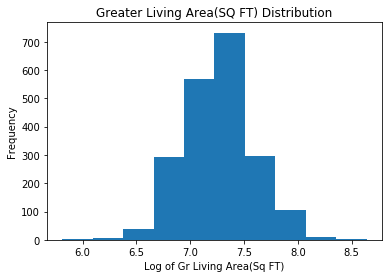

In [426]:
ax= ames_train['GRlivingArealog'].plot(kind = 'hist', title = 'Greater Living Area(SQ FT) Distribution' )

ax.set_xlabel("Log of Gr Living Area(Sq FT)")

## Feature Engineering

#### Scaling Ordinal Features

Dictionary for the most frequent ordinals. This is universal for many columns. Will map.

I chose a 1-6 scale because I believe none should have a 1 value as it exists. 0 would mean it doesnt exist

In [427]:


most_freuquent=   {

       'Ex':6,
       'Gd':5,
       'TA':4,
       'Fa':3,
       'Po':2,
       'NA':1
    
        
    
}



In [428]:
##map ordinal cols to specified columns

ames_train["Exter Qual"] = ames_train["Exter Qual"].map(most_freuquent)
ames_train["Exter Cond"] = ames_train["Exter Cond"].map(most_freuquent)
ames_train['Bsmt Cond'] = ames_train["Bsmt Cond"].map(most_freuquent)
ames_train['Heating QC'] = ames_train['Heating QC'].map(most_freuquent)
ames_train['Kitchen Qual'] = ames_train['Kitchen Qual'].map(most_freuquent)
ames_train['Garage Qual'] = ames_train['Garage Qual'].map(most_freuquent)
ames_train['Bsmt Qual'] = ames_train['Bsmt Qual'].map(most_freuquent)
ames_train['Fireplace Qu'] = ames_train['Fireplace Qu'].map(most_freuquent)
ames_train['Garage Cond'] = ames_train['Garage Cond'].map(most_freuquent)
ames_train['Pool QC'] = ames_train['Pool QC'].map(most_freuquent)


In [429]:
##map ordinal cols to specified columns to validation set

ames_validation["Exter Qual"] = ames_validation["Exter Qual"].map(most_freuquent)
ames_validation["Exter Cond"] = ames_validation["Exter Cond"].map(most_freuquent)
ames_validation['Bsmt Cond'] = ames_validation["Bsmt Cond"].map(most_freuquent)
ames_validation['Heating QC'] = ames_validation['Heating QC'].map(most_freuquent)
ames_validation['Kitchen Qual'] = ames_validation['Kitchen Qual'].map(most_freuquent)
ames_validation['Garage Qual'] = ames_validation['Garage Qual'].map(most_freuquent)
ames_validation['Bsmt Qual'] = ames_validation['Bsmt Qual'].map(most_freuquent)
ames_validation['Fireplace Qu'] = ames_validation['Fireplace Qu'].map(most_freuquent)
ames_validation['Garage Cond'] = ames_validation['Garage Cond'].map(most_freuquent)
ames_validation['Pool QC'] = ames_validation['Pool QC'].map(most_freuquent)

Garage finish, 1-4 scale. Finished- No Garage at all

In [430]:


garage_fin=   {

       'Fin':4,
       'RFn':3,
       'Unf':2,
       'NA':1,
    
}

In [431]:
##map to columns

ames_train['Garage Finish'] = ames_train['Garage Finish'].map(garage_fin)
ames_validation['Garage Finish'] = ames_validation['Garage Finish'].map(garage_fin)

Lot shape with a 1-4 scale

In [432]:


lot_shape= {

       'Reg':4,
       'IR1':3,
       'IR2':2,
       'IR3':1
        }

In [433]:
##map to columns

ames_train['Lot Shape'] = ames_train['Lot Shape'].map(lot_shape)
ames_validation['Lot Shape'] = ames_validation['Lot Shape'].map(lot_shape)


Utilities with a 1-4 scale

In [434]:

utilities= {

       'AllPub':4,
       'NoSewr':3,
       'NoSeWa':2,
       'ELO':1
        }

In [435]:
##map to column
ames_train['Utilities'] = ames_train['Utilities'].map(utilities)
ames_validation['Utilities'] = ames_validation['Utilities'].map(utilities)


Land Slope witha 1-3 scale


In [436]:

land_slope= {

       'Gtl':3,
       'Mod':2,
       'Sev':1
        }

In [437]:
##Map to Column

ames_train['Land Slope']= ames_train['Land Slope'].map(land_slope)
ames_validation['Land Slope']= ames_validation['Land Slope'].map(land_slope)

Bassment EXPOSURE, 1-5 scale

In [438]:

bsmt_exposure= {
       'Gd':5,
       'Av':4,
       'Mn':3,
       'No':2,
       'NA':1,
    }


In [439]:
##Map to column

ames_train['Bsmt Exposure']= ames_train['Bsmt Exposure'].map(bsmt_exposure)
ames_validation['Bsmt Exposure']= ames_validation['Bsmt Exposure'].map(bsmt_exposure)

Basement Finished. 1-7 scale

In [440]:

bsmt_fin={
      'GLQ':7,
       'ALQ':6,
       'BLQ':5,
       'Rec':4,
       'LwQ':3,
       'Unf':2,
        'NA':1
}

In [441]:
##Map to Column- .mpa maps function to df


ames_train['BsmtFin Type 1'] = ames_train['BsmtFin Type 1'].map(bsmt_fin)
ames_train['BsmtFin Type 2'] = ames_train['BsmtFin Type 2'].map(bsmt_fin)
ames_validation['BsmtFin Type 1'] = ames_validation['BsmtFin Type 1'].map(bsmt_fin)
ames_validation['BsmtFin Type 2']= ames_validation['BsmtFin Type 2'].map(bsmt_fin)

Electric 1-6 scale

In [442]:

electric={

       'SBrkr':6,
       'FuseA':5,
       'FuseF':4,
       'FuseP':3,
       'Mix':2,
       'NA': 1
}

In [443]:
##Map to Function
ames_train['Electrical']= ames_train['Electrical'].map(electric)
ames_validation['Electrical']= ames_validation['Electrical'].map(electric)

Functional 1-8 Scale

In [444]:

functional=   {

       'Typ':8,
       'Min1':7,
       'Min2':6,
       'Mod':5,
       'Maj1':4,
       'Maj2':3,
        'Sev':2,
        'Sal':1
}

In [445]:
##Map to column
ames_train['Functional']= ames_train['Functional'].map(functional)
ames_validation['Functional']= ames_validation['Functional'].map(functional)

Paved Drive 0,2. In this case 0 means doesnt exist

In [446]:

paved_drive = {
    
       'Y':2,
       'P':1,
       'N':0
    
}

In [447]:
##Map to column
ames_train['Paved Drive'] = ames_train['Paved Drive'].map(paved_drive)
ames_validation['Paved Drive'] = ames_validation['Paved Drive'].map(paved_drive)

Fences 1-5

In [448]:

fences = {
        
       'GdPrv':5,
       'MnPrv':4,
       'GdWo':3,
       'MnWw':2,
       'NA':1
    
    
}

In [449]:
##Map to columns
ames_train['Fence'] = ames_train['Fence'].map(fences)
ames_validation['Fence'] = ames_validation['Fence'].map(fences)

#### Newly Created Features

In [450]:
## Create a new feature for Square feet of the porch.

## Add Together these columns:

##-Open Porch SF (Continuous): Open porch area in square feet

##-Enclosed Porch (Continuous): Enclosed porch area in square feet

##-3-Ssn Porch (Continuous): Three season porch area in square feet

##-Screen Porch (Continuous): Screen porch area in square feet

def feature_engineers(df):
        df['SqftPorch'] = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch']
        df['TotalSqFt'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
        df['totalbathroom'] = df['Bsmt Full Bath'] + .5 * df['Bsmt Half Bath']+ df['Full Bath'] + .5 * df['Half Bath']
        df['Garage Interaction']= df['Garage Qual'] * df['Garage Cars']
        df['average room size'] = df['GRlivingArealog']/ (np.log(df['TotRms AbvGrd']))
        df['Ability to Build Landscape'] = df['Lot Shape'] * df['Land Contour_Lvl']

        
feature_engineers(ames_train)

feature_engineers(ames_validation)



In [451]:
ames_train.head()

,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,GRlivingArealog,SqftPorch,TotalSqFt,totalbathroom,Garage Interaction,average room size,Ability to Build Landscape
0,0.0,13517,3,4,3,6,8,1976,2005,289.0,...,0,0,0,7.299121,44,2204.0,2.5,8.0,4.073717,3
1,43.0,11492,3,4,3,7,5,1996,1997,132.0,...,0,0,0,7.660114,74,3035.0,3.5,8.0,3.683736,3
2,68.0,7922,4,4,3,5,7,1953,2007,0.0,...,0,0,0,6.963190,52,2114.0,2.0,4.0,4.326473,4
3,73.0,9802,4,4,3,5,5,2006,2007,0.0,...,0,0,0,7.275172,0,1828.0,2.5,8.0,3.738699,4
4,82.0,14235,3,4,3,6,8,1900,1993,0.0,...,0,0,0,7.275865,59,2121.0,2.0,8.0,4.060737,3


### Features:

- Landscaping: Landscaping is a key part of a comfortable home. Especially in the midwest where people love to garden.I want to see if the shape of the lot interacted with  a level contour will affect sales price. An interaction term is used

- Average Room Size - Modern homes tend to have a very large living space and are preferred by millenials. I want to see if higher the ratio has a positive impact on sales price

- Created a function that shows the quality and the size of the garage. The higher the quality and bigger the size the more likely the price will be higher. A large garage could be of low quality. This is a feature that could impact sales price

- Total Bathrooms- Just add each bathroom for total amount in the house

- Total Square feet- Total sq feet of the house

- SQ ft porch- total sq feet of the porch

Drop columns that were used in new feature engineering. Avoid multicolinearity

In [452]:

ames_train.drop(columns=['Enclosed Porch', '3Ssn Porch', 
                           'Screen Porch', 'Total Bsmt SF', 
                           '1st Flr SF', '2nd Flr SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 
                           'Full Bath', 'Half Bath', 'Open Porch SF'], inplace = True)

In [453]:
##Do the same for validations set
ames_validation.drop(columns=['Enclosed Porch', '3Ssn Porch', 
                           'Screen Porch', 'Total Bsmt SF', 
                           '1st Flr SF', '2nd Flr SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 
                           'Full Bath', 'Half Bath', 'Open Porch SF'], inplace = True)

### Check to see which columns exist in train vs test

ames train columns versus ames test columns

In [454]:


different_cols = set(ames_train.columns) - set(ames_validation.columns)


different_cols

{'Condition 2_Feedr',
 'Condition 2_PosN',
 'Condition 2_RRAe',
 'Condition 2_RRAn',
 'Condition 2_RRNn',
 'Exterior 1st_CBlock',
 'Exterior 1st_ImStucc',
 'Exterior 1st_Stone',
 'Exterior 2nd_Stone',
 'Heating_OthW',
 'Heating_Wall',
 'MS SubClass_150',
 'MS Zoning_C (all)',
 'Misc Feature_Gar2',
 'Misc Feature_TenC',
 'Neighborhood_GrnHill',
 'Neighborhood_Landmrk',
 'Roof Matl_CompShg',
 'Roof Matl_Membran',
 'SalePricelog'}

In [455]:
##for loop to engineer new features in test to be 0. This will help us fit our model

for missing_cols in different_cols:
        ames_validation[missing_cols] = 0


In [456]:
##Check to see different columns

different_cols_test = set(ames_validation.columns) - set(ames_train.columns)
different_cols_test

{'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_GasA',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD'}

In [457]:
##Do the same on the train set
for missing_cols in different_cols_test:
    ames_train[missing_cols] = 0


In [458]:
#.shape

ames_train.shape

(2051, 215)

In [459]:


ames_validation.shape

(878, 215)

Shape is the same

Order the columns to make it equal

In [460]:
ames_validation = ames_validation[ames_train.columns]

- Heatmap for correlations with ordinals and new features
- Making those columns numeric and dummyfying thme helps enhance features.

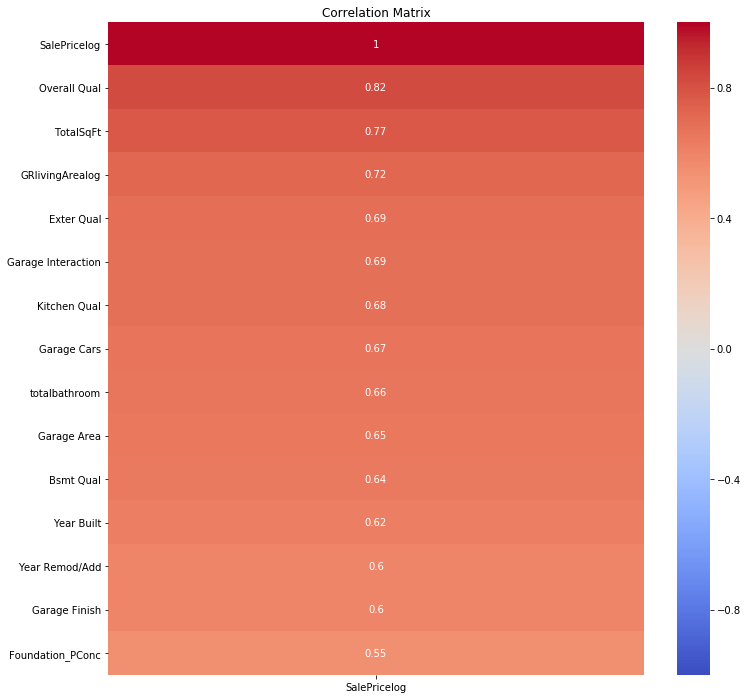

In [461]:


plt.figure(figsize=(12,12))
plt.title("Correlation Matrix")
sns.heatmap(ames_train.corr()[['SalePricelog']].sort_values('SalePricelog', ascending = False).head(15), 
            annot = True, cmap = "coolwarm", vmax = 1, vmin = -1)

#### The correlation heat map shows that certain ordinals and new engineered features actually make an impact on sales price.

- Total Square Feet- High correlation with sale price

- Garage Interaction- Newly Engineered feature. Shows that a high quality spacious garage affects sales price

- Kitchen Quality- Everyone wants a nice kitchen. Ordinal column that affects sale price

These terms are of interest as a basic model for predicting sales price.

## Model Preparation

### Baseline Model

Basline Model is to predict the average mean of y and test residuals from that. 

In [462]:
y = ames_train['SalePricelog']

In [463]:
baseline = y.mean()
# store $ residuals from model 1
resids_baseline = np.exp(y) - np.exp(baseline)

### Linear  Model 1

#### Feature Selection: First Model

I decided to use the features with the highest correlation from the heat map. I decided to to do this to test these features and see if I can get a high R squared. There is a limitation with this model. I wanted to test linearity between X and Y and look to see if these variables have a linear relationship with sales price

In [464]:
features = ['Overall Qual', 'TotalSqFt', 'GRlivingArealog', 'Exter Qual', 'Garage Interaction', 'Kitchen Qual',
           
           'Garage Cars', 'totalbathroom', 'Garage Area', 'Bsmt Qual', 'Year Built', 'Year Remod/Add', 
            'Garage Finish', 'Foundation_PConc', 'Ability to Build Landscape', ]


In [465]:
X = ames_train[features]
y = ames_train['SalePricelog']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 35)


lr = LinearRegression()
print(cross_val_score(lr, X_train, y_train, cv=3))
print(cross_val_score(lr, X_train, y_train, cv=3).mean())

[0.82364264 0.84002844 0.8477822 ]
0.8371510955555727


In [466]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [467]:
pred_train = lr.predict(X_train) 
                                      
pred_test = lr.predict(X_test)   

# Score it and round to 3 dp
print("Training Set R^2 Score is:", np.round(lr.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(lr.score(X_test, y_test),3))

Training Set R^2 Score is: 0.844
Testing Set R^2 Score is: 0.842


##### Analysis of Model 1.

It seems that 84% of the varaince of the data can be explained by the training model. And 82% of the variance of the data can be explained by the testing set. The limitation of this model is that it repersents high bias. I decided to reduce the features(x values to 15 features compared to the total of 218. The next model will include all features to improve R squared

In [468]:
def plot_predictions(model_name, y_train_pred ,y_train_actual):
    plt.scatter(y_train_actual, y_train_pred, c = "blue", marker = "s", label = "Training data")
    plt.title("Regression Sales Price")
    plt.xlabel("$\hat{y}$ = Actual SalePrice($)")
    plt.ylabel("$y$ = Predicted SalePrice($)")
    plt.legend(loc = "upper left")
    plt.plot([y_train_actual.min(), y_train_actual.max()], [y_train_actual.min(), y_train_actual.max()], c='red')
    plt.tight_layout()

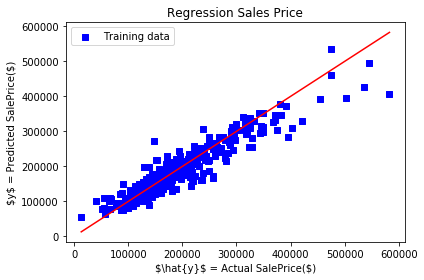

In [469]:
plot_predictions(lr, np.exp(pred_test), np.exp(y_test))

#### Analysis of Actual vs Predicted

The graph shows that many of the values are represented by the line of best fit(actual = predicted). One observation I made from this graph is that the model is unable to predict at higher sales prices. This could be due to the fact that we dont have a good sense of the willigness and behavior of consumers. The behavioral factors of customers are a major indicator of the sales price of homes. For tax purposes, we can predict sales price and have a good forecast of capital gains at year end. Will improve model to test all features

In [470]:
residuals_1 = np.exp(y_test)- np.exp(pred_test)

Text(0.5, 1.0, 'Model 1 Residuals by Sale Price')

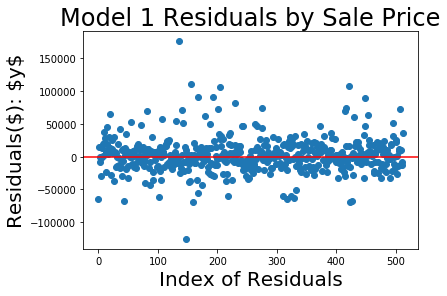

In [471]:
plt.scatter(range(len(residuals_1)), residuals_1)
plt.axhline(0,color = 'red')
plt.xlabel("Index of Residuals", fontsize = 20)
plt.ylabel("Residuals($): $y$", fontsize = 20)
plt.title('Model 1 Residuals by Sale Price', fontsize = 24)

### Model 2

#### Select Features. Instantiate Model

I decided to use all the features given in the data set. I decided to to do this to test all features and see if more of the variance in the data can be explained by our model. In addition, I believe adding all the features will better predict houses at higher sales prices because it reperesents different customer tastes. The marginal increase of sales price from each feature will be shown with this model.

In [472]:
##set x value by dropping sales price log. Want to have all features

ames_x = ames_train.drop('SalePricelog', axis = 1)
ames_validation = ames_validation.drop('SalePricelog', axis = 1)

##### Keep all features for first model and asses r squared score. This will help us understand how our model fits the data. We want more than 90% of the data to be explained by the model. Use Cross val score with different partitions of training and test.


In [473]:


X = ames_x
y = ames_train['SalePricelog']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 35)


lr = LinearRegression()
print(cross_val_score(lr, X_train, y_train, cv=3))
print(cross_val_score(lr, X_train, y_train, cv=3).mean())

[0.83594927 0.81776433 0.80469614]
0.819469917063656


#### Fit Model

In [474]:
##fit model
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Predict

In [475]:
##predict on validation set. 

yhat_train = lr.predict(X_train) 
                                      
yhat_test = lr.predict(X_test)   

# Score it and round to 3 dp
print("Training Set R^2 Score is:", np.round(lr.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(lr.score(X_test, y_test),3))

Training Set R^2 Score is: 0.937
Testing Set R^2 Score is: 0.948


##### Analysis of Model 2

It seems that 93.7% of the varaince in the data can be explained by the training model. And 94.8% of the variance of the data can be explained by the testing set. Due to time constraints, I wasnt able to create a function that evaluated the model one feature by one feature. To enhance this, I would create a function that added features one by one to find the most optimal model. I decided to increase the features(x values to 218 features compared to the total of 15. 

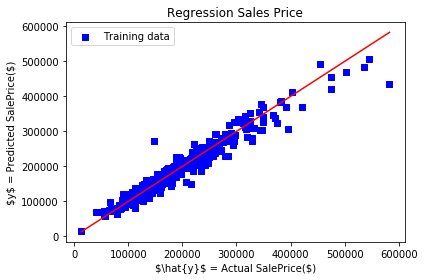

In [476]:
plot_predictions(lr, np.exp(yhat_test), np.exp(y_test))

#### Analysis of Actual vs Predicted

The graph shows that many of the values are represented by the line of best fit(actual = predicted). One observation I made from this model 2 graph is that the model is better able to predict at higher sales prices than the previous model. This could be due to the fact that we have a better sense that the increase in factors actually help us have a better understanding of consumer behavior. The behavioral factors of customers are a major indicator of the sales price of homes. For tax purposes, our model 2 is best suited to predict capital gains at year end. Will test lasso and ridge for regularization

#### Find coeficients for model. 

We want to see which variables have a pvalue less than 5% for statistical significance on predicting sales
price. This could help us identify non sig variables and use this to trim model

In [477]:


X_adj = X
X_adj["intercept"] = 1

model2_summary = sm.OLS(y, X_adj).fit()
model2_summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePricelog   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     140.9
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:30:16   Log-Likelihood:                 1796.9
No. Observations:                2051   AIC:                            -3182.
Df Residuals:                    1845   BIC:                            -2023.
Df Model:                         205                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Lot Frontage                   0.0002   9.15e-05      1.848      0.065   -1.04e-05       0.000
Lot Area                    3.438e-06   5.37e-07      6.399      0.000    2.38e-06    4.49e-06
Lot Shape                      0.0047      0.015      0.312      0.755      -0.025       0.034
Utilities                      0.1122      0.063      1.786      0.074      -0.011       0.235
Land Slope                     0.0041      0.014      0.301      0.764      -0.022       0.031
Overall Qual                   0.0445      0.004     11.459      0.000       0.037       0.052
Overall Cond                   0.0425      0.003     12.908      0.000       0.036       0.049
Year Built                     0.0022      0.000      7.240      0.000       0.002       0.003
Year Remod/Add                 0.0005      0.000      2.170      0.030     4.4e-05       0.001
Mas Vnr Area                5.691e-05   2.31e-05      2.462      0.014    1.16e-05       0.000
Exter Qual                     0.0179      0.008      2.217      0.027       0.002       0.034
Exter Cond                    -0.0046      0.008     -0.587      0.557      -0.020       0.011
Bsmt Qual                      0.0068      0.006      1.096      0.273      -0.005       0.019
Bsmt Cond                      0.0004      0.007      0.060      0.952      -0.014       0.015
Bsmt Exposure                  0.0127      0.003      3.939      0.000       0.006       0.019
BsmtFin Type 1                 0.0035      0.002      1.829      0.068      -0.000       0.007
BsmtFin SF 1                3.666e-05   3.87e-05      0.948      0.343   -3.92e-05       0.000
BsmtFin Type 2                -0.0032      0.004     -0.733      0.464      -0.012       0.005
BsmtFin SF 2                1.116e-05   4.55e-05      0.245      0.806   -7.81e-05       0.000
Bsmt Unf SF                -3.663e-05   3.83e-05     -0.957      0.339      -0.000    3.85e-05
Heating QC                     0.0102      0.004      2.832      0.005       0.003       0.017
Electrical                    -0.0077      0.007     -1.056      0.291      -0.022       0.007
Low Qual Fin SF             2.315e-05   6.43e-05      0.360      0.719      -0.000       0.000
Bedroom AbvGr                 -0.0089      0.005     -1.780      0.075      -0.019       0.001
Kitchen AbvGr                 -0.0188      0.025     -0.760      0.447      -0.067       0.030
Kitchen Qual                   0.0210      0.006      3.369      0.001       0.009       0.033
TotRms AbvGrd                  0.0067      0.007      0.999      0.318      -0.006       0.020
Functional                     0.0347      0.004      8.369      0.000       0.027       0.043
Fireplaces                     0.0144      0.009      1.676      0.094      -0.002       0.031
Fireplace Qu                   0.0008      

Look at pvalues below .05 for significance. 

###### Examples: <.05

- Overall Quality
- Overall Condition
- Year Bilit
- Total Bathroom
- Garage Interaction Term

###### Surprises: > .05

- Ability to build landscape
- Average Room Size
- Fireplace Qu


In [478]:
residuals = np.exp(y_test)-np.exp(yhat_test)

In [479]:
residuals.mean()

1017.2807050137453

Text(0.5, 1.0, 'Model 2 Resiudals by Sale Price')

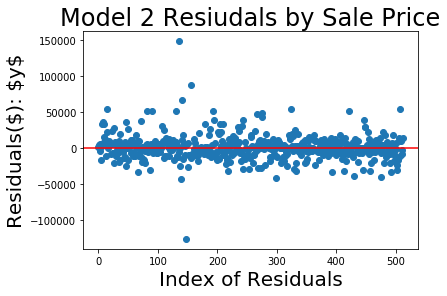

In [480]:
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0,color = 'red')
plt.xlabel("Index of Residuals", fontsize = 20)
plt.ylabel("Residuals($): $y$", fontsize = 20)
plt.title('Model 2 Resiudals by Sale Price', fontsize = 24)

Residual Plot

In this plot each point is predicted sales price, where the prediction made by the model is on the x-axis, and the accuracy of the prediction is on the y-axis. The distance from the line at 0 is how bad the prediction was for that value. Residulas is derived by taking the observed minus predicted. This confirms that there is more variability at super low and high prices. This model could be better at predicting extremes with potential buyer information.

#### Submit

### Model 3: Ridge Model

Scale data. All data should be on same scale relative to mins and max of respective features. This is useful for regularization in Ridge model. Used all features from model 2(higher r2 than model 1)

In [481]:
sc = StandardScaler()
# Fit AND transform Standard Scaler to overfit data in one step.
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [482]:
from sklearn.linear_model import RidgeCV

In [483]:
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(Z_train, y_train)

In [484]:
ridge_model.alpha_

376.49358067924675

In [485]:
print("Train Set R^2 Score is:", ridge_model.score(Z_train, y_train))
print("Testing Set R^2 Score is:", ridge_model.score(Z_test, y_test))

Train Set R^2 Score is: 0.9197412739792304
Testing Set R^2 Score is: 0.8842197768707809


Seems like the Ridge model overfit the data, training score is greater than testing score. This model sets to 
zero out coeficients so we can update model without 0 coeficients. Due to time constraints we will do that if model 2 does not suffice for client

In [486]:
ridge_model.coef_

array([ 7.27199266e-04,  1.20713307e-02, -2.44146566e-03,  0.00000000e+00,
       -3.48628844e-03,  4.92036543e-02,  3.16586512e-02,  2.13129811e-02,
        1.57805918e-02,  7.52516468e-03,  1.70603978e-02,  4.66108277e-03,
        1.75112991e-02,  2.63756959e-03,  1.67736691e-02,  1.50829337e-02,
        1.13926574e-02, -1.96060579e-03,  4.49304537e-03,  2.12881658e-03,
        1.31157900e-02,  1.85585982e-03,  9.15060565e-04,  5.31987893e-03,
       -5.62745976e-03,  1.98809863e-02,  1.61632654e-02,  1.18280125e-02,
        1.07080731e-02,  1.39584875e-02, -6.93782012e-03,  5.74287594e-03,
        1.33586575e-02,  6.97043568e-03,  6.94029647e-03,  8.28370001e-03,
        1.32404113e-02,  9.87403761e-03,  2.30727549e-03, -1.16204186e-02,
       -5.22521467e-05, -2.80587576e-02,  1.07671286e-03, -4.56761060e-03,
       -4.40620163e-03, -9.90329055e-03, -2.07155153e-03, -9.05294018e-04,
        1.24140795e-02, -1.36557848e-02, -2.13056410e-03,  3.25616856e-03,
        3.29427200e-03,  

In [487]:
best_features = [tup for tup in list(zip(ridge_model.coef_,X_test.columns)) if tup[0] != 0]
best_features.sort(reverse=False) #descending order
best_features

[(-0.02805875756830594, 'Misc Val'),
 (-0.015836634359415888, 'Neighborhood_Edwards'),
 (-0.01365578481519705, 'MS SubClass_30'),
 (-0.012803915081335037, 'Heating_Grav'),
 (-0.012585247664112061, 'MS Zoning_C (all)'),
 (-0.012506003512368817, 'Neighborhood_MeadowV'),
 (-0.0121793220078094, 'Bldg Type_Twnhs'),
 (-0.012150914759737383, 'Neighborhood_OldTown'),
 (-0.011620418606282623, 'Pool QC'),
 (-0.01115577211234216, 'Roof Style_Mansard'),
 (-0.010362748743233775, 'Exterior 1st_BrkComm'),
 (-0.009903290554071997, 'MS SubClass_160'),
 (-0.009371571705786712, 'Bldg Type_TwnhsE'),
 (-0.00786961324723592, 'MS Zoning_RM'),
 (-0.007447245616050107, 'Neighborhood_NAmes'),
 (-0.006937820121868963, 'Garage Yr Blt'),
 (-0.006810810010868142, 'Garage Type_Detchd'),
 (-0.0057207142635334555, 'Garage Type_CarPort'),
 (-0.005627459759378086, 'Kitchen AbvGr'),
 (-0.005624772328151138, 'Condition 1_RRAe'),
 (-0.005187222116244021, 'average room size'),
 (-0.004828603967538675, 'Neighborhood_Sawyer')

In [488]:
preds_ridge = np.exp(ridge_model.predict(Z_test))
##stores residuals model 3
resids_ridge = np.exp(y_test) - preds_ridge

Text(0.5, 1.0, 'Model 3 Resiudals by Sale Price')

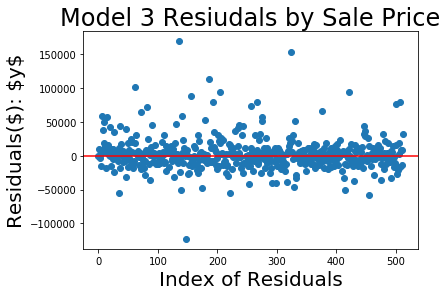

In [489]:
plt.scatter(range(len(resids_ridge)), resids_ridge)
plt.axhline(0,color = 'red')
plt.xlabel("Index of Residuals", fontsize = 20)
plt.ylabel("Residuals($): $y$", fontsize = 20)
plt.title('Model 3 Resiudals by Sale Price', fontsize = 24)

The ridge model does not well at predicting high sales prices. High variation at higer prices. Ridge should be used with a high variance linear regression model.Ridge model does not 0 out coeficients so it might not be useful to use this model if we want to improve our feature selection

### Model 4 Lasso Regression

Same as before, I chose to keep all fetures similar to model 2 and 3. Lasso regression uses penalty term to 0 
out coefficients. This can help us remove those features. Due to time constraints, we will remove coeficients based on additional client request

In [490]:
from sklearn.linear_model import LassoCV

In [491]:
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

# Fit model using best ridge alpha!
lasso_model = lasso_model.fit(Z_train, y_train)

In [492]:
lasso_model.alpha_

0.004037017258596553

In [493]:
print(lasso_model.score(Z_train, y_train))
print(lasso_model.score(Z_test, y_test))

0.9199495889052195
0.8888985262126209


In [494]:
best_features_lasso = [tup for tup in list(zip(lasso_model.coef_,X_test.columns)) if tup[0] != 0]
best_features_lasso.sort(reverse=False) #descending order
best_features_lasso

[(-0.025890303521369833, 'Misc Val'),
 (-0.015941997484475435, 'MS SubClass_160'),
 (-0.012320502401639262, 'Heating_Grav'),
 (-0.012108361577625189, 'Neighborhood_Edwards'),
 (-0.01113319002492214, 'MS Zoning_C (all)'),
 (-0.010945967283168191, 'MS Zoning_RM'),
 (-0.009763330204033102, 'Exterior 1st_BrkComm'),
 (-0.009134719864263669, 'Bldg Type_Twnhs'),
 (-0.00896157194621144, 'Roof Style_Mansard'),
 (-0.008470989840854249, 'Neighborhood_OldTown'),
 (-0.00783279236540063, 'Pool QC'),
 (-0.007445109054364804, 'Kitchen AbvGr'),
 (-0.006208696868930098, 'Neighborhood_MeadowV'),
 (-0.004298926055324609, 'House Style_2Story'),
 (-0.0025198893125302755, 'Garage Type_CarPort'),
 (-0.002343255136996191, 'Exterior 1st_Stucco'),
 (-0.002107409745039929, 'Condition 1_RRAe'),
 (-0.002028335264145877, 'MS SubClass_150'),
 (-0.0017531793780764377, 'Land Slope'),
 (-0.001381626926446386, 'Yr Sold'),
 (-0.0006920536846413326, 'Neighborhood_SawyerW'),
 (-0.0005401426612529512, 'House Style_2.5Fin'),


In [495]:
preds_lasso = np.exp(lasso_model.predict(Z_test))
##stores residuals model 4
resids_lasso = np.exp(y_test) - preds_ridge

Text(0.5, 1.0, 'Model 4 Resiudals by Sale Price')

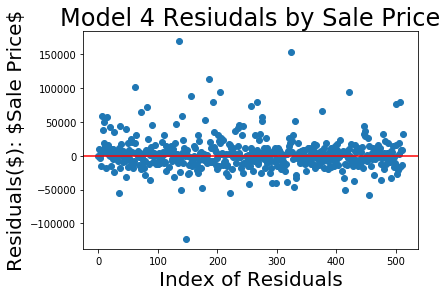

In [496]:
plt.scatter(range(len(resids_lasso)), resids_lasso)
plt.axhline(0,color = 'red')
plt.xlabel("Index of Residuals", fontsize = 20)
plt.ylabel("Residuals($): $Sale Price$", fontsize = 20)
plt.title('Model 4 Resiudals by Sale Price', fontsize = 24)

Lasso model does worse as well predicting high sales prices. Lasso zeroes out coeficients and can be used to select optimal variables. Unlike ridge, lasso actually 0's out coeficients and shrinks parameters

## Model Selection

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|.84|.84| 
|**Model 2**|*Linear*|.93|.94|
|**Model 3**|*Ridge*|.91|.88|
|**Model 4**|*Lasso*|.91|.88|




Based on R2 scores listed above,  and residual plots, I have decided to choose model 2 to deliver to our clients in predicting sales prices, and capital gains at year end. This model will be best suited for our clients to prepare for year end tax planning in the aftermath of Tax cut and job act in which Trump issued. Model 2 does the best in predicting high sales prices, and more of the variance in the data can be explained by our model. We want to deliver high level tax solutions to our clients with the least amount of residuals.


## Conclusions

After the implementation of the tax cut and jobs act, our tax consulting firm was hired to find the most optimal model in predicting sale price. Sale price is a great predictior that can help our clients compute capital gains in order for tax planning purposes in the 2020 year. Based on my teams findings, we are offering our client a linear regression model, where 94% of the variance in the data can be explained by the model. Due to time contraints, we were not able to implement a function that allows us to test different features to find the most optimal model. Using all the features in the data, allowed us for more customization in our model and better serve our client. 

## Recommendations

- Gather city infromation and test opportunity zones

- Feature Engineering can enhance model and be better predictors

- Deploy addition models such as Random Forrest, Neural Networks

- Gather more data from client to compute actual tax savings

- Carefully selct features based on coeficients and p values



## Resources

https://www.washingtonpost.com/news/where-we-live/wp/2015/04/01/how-much-value-does-landscaping-add-to-your-home-when-selling/

https://www.irs.gov/www.irs.gov › newsroom › opportunity-zones-frequently-asked-quest...
Opportunity Zones Frequently Asked Questions | Internal ...
    
    